In [102]:
datasets = ['CUB', 'Derm7pt', 'RIVAL10']
use_dataset = datasets[1]

In [103]:
import os
import sys
import torch
import joblib

notebook_dir = os.getcwd()
project_root_path = os.path.dirname(notebook_dir)
sys.path.insert(0, project_root_path)

from src.config import PROJECT_ROOT, CUB_CONFIG, DERM7PT_CONFIG, RIVAL10_CONFIG  # noqa: E402
import numpy as np  # noqa: E402
import matplotlib.pyplot as plt  # noqa: E402

In [104]:
if use_dataset == 'CUB':
    config_dict = CUB_CONFIG
    DATASET_PATH =  os.path.join(PROJECT_ROOT, 'output', 'intervention', 'CUB')
elif use_dataset == 'Derm7pt':
    config_dict = DERM7PT_CONFIG
    DATASET_PATH =  os.path.join(PROJECT_ROOT, 'output', 'intervention', 'Derm7pt')
else:
    config_dict = RIVAL10_CONFIG
    DATASET_PATH =  os.path.join(PROJECT_ROOT, 'output', 'intervention', 'RIVAL10')

In [105]:
num_concepts = config_dict['N_TRIMMED_CONCEPTS']
num_classes = config_dict['N_CLASSES']

In [106]:
device = torch.device("cuda" if torch.cuda.is_available()
                    else "mps" if torch.backends.mps.is_available()
                    else "cpu")
print(f"Using device: {device}")

Using device: mps


# Load and Transform Data

In [107]:
# Load data for linear model
lin_C_hat = np.load(os.path.join(DATASET_PATH, 'C_hat_linear.npy'))
lin_Y = np.load(os.path.join(DATASET_PATH, 'Y_linear.npy'))
lin_model = joblib.load(os.path.join(DATASET_PATH, 'lin_model.joblib'))

# Load data for CLC model
clc_C_hat = torch.load(os.path.join(DATASET_PATH, 'C_hat_clc.npy'))
clc_Y = torch.load(os.path.join(DATASET_PATH, 'Y_clc.npy'))
clc_model = torch.load(os.path.join(DATASET_PATH, 'clc_model.pth'),
                    weights_only=False, map_location=device)

# # Load class-level concepts
# class_level_concepts_path = os.path.join(PROJECT_ROOT, 'output', use_dataset, 'class_level_concepts.npy')
# class_level_concepts = np.load(class_level_concepts_path)

In [108]:
# # Generate class-level concept values for each instance
# clc_l_concept_values = []
# for y in clc_Y:
#     clc_l_concept_values.append(class_level_concepts[y])

# clc_l_concept_values = np.array(clc_l_concept_values)
# clc_l_concept_values = torch.tensor(clc_l_concept_values, device=device, dtype=torch.float32)

In [109]:
# Check initial model accuracy
print(f"Linear model accuracy: {lin_model.score(lin_C_hat, lin_Y):.4f}")

with torch.no_grad():
    clc_Y_pred = clc_model.predict(clc_C_hat)
    clc_accuracy = (clc_Y_pred == clc_Y).sum().item()/len(clc_Y_pred)
    print(f"CLC model accuracy: {clc_accuracy:.4f}")

Linear model accuracy: 0.0000
CLC model accuracy: 0.0719


# Intervention Utilities

In [110]:
def compute_intervention_matrices_1(model, C_hat, Y_test):
    model_weights = model.coef_

    concept_gain_rankings = np.zeros_like(C_hat)
    expected_values = np.zeros_like(C_hat)

    for instance_idx, concept_vector in enumerate(C_hat):
        true_label = Y_test[instance_idx]
        class_weights = model_weights[true_label]
        concept_gains = np.zeros(len(class_weights))
        instance_expected_vals = np.zeros(len(class_weights))

        for concept_idx, concept_weight in enumerate(class_weights):
            # Binary value based on concept weight direction
            expected_concept_value = 1 if concept_weight > 0 else 0
            instance_expected_vals[concept_idx] = expected_concept_value

            # Calculate gain by comparing expected vs pred label, scaled by weight
            concept_gains[concept_idx] = ((expected_concept_value - concept_vector[concept_idx]) * concept_weight)

        expected_values[instance_idx] = instance_expected_vals
        concept_gain_rankings[instance_idx] = (concept_gains)

    concept_indices_by_gain = np.argsort(concept_gain_rankings, axis=1)[:, ::-1]

    return concept_indices_by_gain, expected_values

In [126]:
def compute_intervention_matrices_2(model, C_hat, Y_test):
    model_weights = model.coef_
    weight_matrix = []

    for idx in range(len(C_hat)):
        instance_label = Y_test[idx]
        weight_matrix.append(model_weights[instance_label])

    weight_matrix = np.array(weight_matrix)
    weight_indices_sorted = np.argsort(weight_matrix, axis=1)[:, ::-1]

    return weight_indices_sorted

In [127]:
def compute_prototype_gain_matrices(model, C_hat, Y_true):
    prototypes = model.get_binary_prototypes()

    gain_matrix = np.zeros((C_hat.shape[0], C_hat.shape[1]))
    expected_values = np.zeros((C_hat.shape[0], C_hat.shape[1]))

    for instance_idx, concept_vector in enumerate(C_hat):
        pred_label = Y_true[instance_idx]
        prototype = prototypes[pred_label].cpu().detach().numpy()
        gain_vector = np.abs(prototype-concept_vector.cpu().detach().numpy())
        gain_matrix[instance_idx] = gain_vector
        expected_values[instance_idx] = prototype

    concept_indices_by_gain = np.argsort(gain_matrix, axis=1)[:, ::-1]
    expected_values = torch.tensor(expected_values, device=device, dtype=torch.float32)

    return concept_indices_by_gain, expected_values

In [128]:
# def compute_class_level_gain_matrices(C_hat, Y_true, class_level_concepts):
#     gain_matrix = np.zeros((C_hat.shape[0], C_hat.shape[1]))

#     for instance_idx, concept_vector in enumerate(C_hat):
#         pred_label = Y_true[instance_idx]
#         clc = class_level_concepts[pred_label]
#         gain_vector = np.abs(clc-concept_vector.cpu().detach().numpy())
#         gain_matrix[instance_idx] = gain_vector

#     concept_indices_by_gain = np.argsort(gain_matrix, axis=1)[:, ::-1]

#     return concept_indices_by_gain

In [129]:
def run_numpy_intervention(model, C_hat, Y_true, concept_indices_by_gain, expected_values):
    C_hat_intervened = C_hat.copy()

    # Calculate initial accuracy
    initial_predictions = model.predict(C_hat_intervened)
    misclassified_mask = (initial_predictions != Y_true)

    accuracy = model.score(C_hat_intervened, Y_true)
    accuracies = [accuracy]

    # Run intervention steps
    intervention_step = 0
    while np.any(misclassified_mask) and intervention_step < C_hat.shape[1]:
        # Get misclassified indices
        indices_to_intervene = np.where(misclassified_mask)[0]

        if len(indices_to_intervene) == 0:
            break

        # Select concepts to change based on ranking
        concepts_to_change = concept_indices_by_gain[
            indices_to_intervene, intervention_step
        ]

        # Apply intervention
        C_hat_intervened[indices_to_intervene, concepts_to_change] = \
            expected_values[indices_to_intervene, concepts_to_change]

        # Re-evaluate
        current_predictions = model.predict(C_hat_intervened)
        misclassified_mask = (current_predictions != Y_true)
        accuracy = model.score(C_hat_intervened, Y_true)
        accuracies.append(accuracy)

        intervention_step += 1

    print(f"Intervention completed after {intervention_step} steps")
    print(f"Final accuracy: {accuracies[-1]:.4f}")

    return accuracies

In [130]:
# def predict_nearest_class(C_hat, class_level_concepts):
#     # Convert to numpy if needed
#     if isinstance(C_hat, torch.Tensor):
#         C_hat_numpy = C_hat.cpu().detach().numpy()
#     else:
#         C_hat_numpy = C_hat

#     # Calculate differences between each test instance and all class-level concepts
#     predicted_classes = []

#     for i, test_instance in enumerate(C_hat_numpy):
#         # Calculate absolute differences to each class concept
#         instance_diffs = np.abs(test_instance - class_level_concepts)

#         # Sum the differences along concept dimension to get total deviation for each class
#         instance_distances = np.sum(instance_diffs, axis=1)

#         # Find which class has the minimum distance
#         min_class = np.argmin(instance_distances)
#         predicted_classes.append(min_class)

#     return np.array(predicted_classes)


def run_torch_intervention(model, C_hat, Y_true, concept_indices_by_gain, expected_values, use_clc_d_accuracy=False, class_level_concepts=None):
    # Clone data to avoid modifying originals
    C_hat_intervened = C_hat.clone().detach()
    Y_true_device = Y_true.to(C_hat_intervened.device)
    # Y_true_numpy = Y_true_device.cpu().numpy() if use_clc_d_accuracy else None

    # Get initial predictions and accuracy
    # if use_clc_d_accuracy and class_level_concepts is not None:
    #     # CLC-D specific accuracy calculation using nearest neighbor
    #     predicted_classes = predict_nearest_class(C_hat_intervened, class_level_concepts)
    #     current_accuracy = np.mean(predicted_classes == Y_true_numpy)

    #     # Generate mask for intervention
    #     misclassified_mask = torch.tensor(
    #         predicted_classes != Y_true_numpy,
    #         device=C_hat_intervened.device
    #     )
    # else:
    # Standard accuracy calculation
    with torch.no_grad():
        initial_predictions = model.predict(C_hat_intervened)
    misclassified_mask = (initial_predictions != Y_true_device)
    current_accuracy = (~misclassified_mask).float().mean().item()


    accuracies = [current_accuracy]

    # Run intervention steps
    intervention_step = 0
    while misclassified_mask.any() and intervention_step < C_hat.shape[1]:
        indices_to_intervene = torch.where(misclassified_mask)[0]

        if len(indices_to_intervene) == 0:
            break

        # Select concepts to change
        concepts_to_change = concept_indices_by_gain[
            indices_to_intervene.cpu().numpy(), intervention_step
        ]

        # Apply intervention
        C_hat_intervened[indices_to_intervene, concepts_to_change] = \
            expected_values[indices_to_intervene, concepts_to_change]

        # Re-evaluate with appropriate accuracy calculation
        # if use_clc_d_accuracy and class_level_concepts is not None:
        #     # CLC-D specific accuracy calculation using nearest neighbor
        #     predicted_classes = predict_nearest_class(C_hat_intervened, class_level_concepts)
        #     current_accuracy = np.mean(predicted_classes == Y_true_numpy)

        #     # Update mask
        #     misclassified_mask = torch.tensor(
        #         predicted_classes != Y_true_numpy,
        #         device=C_hat_intervened.device
        #     )
        # else:
        # Standard accuracy calculation
        with torch.no_grad():
            current_predictions = model.predict(C_hat_intervened)
        misclassified_mask = (current_predictions != Y_true_device)
        current_accuracy = (~misclassified_mask).float().mean().item()


        accuracies.append(current_accuracy)
        intervention_step += 1

    print(f"Intervention completed after {intervention_step} steps")
    print(f"Final accuracy: {accuracies[-1]:.4f}")

    return accuracies

In [131]:
def plot_intervention_results(model_results_dict, dataset_name):
    plt.figure(figsize=(6,6))

    line_styles = {
        'LR': '-',
        'CLPC': '--',
        'CLC-D': '-.'
    }

    markers = {
        'LR': 'o',
        'CLPC': 'D',
        'CLC-D': '^'
    }

    # Find the minimum length to ensure consistency
    max_len = max(len(accs) for accs in model_results_dict.values())

    # Plot with distinct styles for each model, trimming to min length
    for model_name, accuracies in model_results_dict.items():
        plt.plot(np.arange(len(accuracies)), accuracies,
                label=model_name,
                # color=colors.get(model_name, 'black'),
                linestyle=line_styles.get(model_name, '-'),
                marker=markers.get(model_name, 'o'),
                markersize=10,
                linewidth=3)

    plt.xlabel("Number of Concepts Intervened", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)
    # plt.title(f"Intervention Efficiency - {dataset_name} Dataset", fontsize=16)
    plt.grid(alpha=0.3)

    # Adjust x-ticks based on dataset
    if dataset_name == 'Derm7pt':
        max_len = max(len(accs) for accs in model_results_dict.values())
        x_ticks = np.arange(0, max_len, 1)
        plt.xticks(x_ticks, x_ticks.astype(int), fontsize=16)
    elif dataset_name == 'RIVAL10':
        max_len = max(len(accs) for accs in model_results_dict.values())
        x_ticks = np.arange(0, max_len)
        plt.xticks(x_ticks, x_ticks.astype(int), fontsize=16)
    else:
        plt.xticks(fontsize=16)

    plt.yticks(fontsize=16)

    plt.legend(fontsize=16, loc='lower right')
    plt.tight_layout()

    output_dir = os.path.join(PROJECT_ROOT, 'output', 'plots', 'intervention')
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, f'{use_dataset}.png'), dpi=600, bbox_inches='tight')
    plt.show()

# Model 1: Logistic Regression Intervention

In [ ]:
# Calculate gain matrices for logistic regression
lr_concept_indices_by_gain, lr_expected_values = compute_intervention_matrices_gain(
    lin_model, lin_C_hat, lin_Y
)

# Run logistic regression intervention
lr_1_accuracies = run_numpy_intervention(
    lin_model, lin_C_hat, lin_Y,
    lr_concept_indices_by_gain, lr_expected_values
)


lr_concept_indices_by_gain, lr_expected_values = compute_intervention_matrices_weight(
    lin_model, lin_C_hat, lin_Y
)

lr_2_accuracies = run_numpy_intervention(
    lin_model, lin_C_hat, lin_Y,
    lr_concept_indices_by_weight, lr_expected_values
)

Intervention completed after 4 steps
Final accuracy: 1.0000


NameError: name 'lr_concept_indices_by_weight' is not defined

# Model 2: CLC-L (Prototype) Intervention

In [ ]:
# Calculate gain matrices for prototype model
proto_concept_indices_by_gain, proto_expected_values = compute_prototype_gain_matrices(
    clc_model, clc_C_hat, clc_Y
)

# Run prototype model intervention
proto_accuracies = run_torch_intervention(
    clc_model, clc_C_hat, clc_Y,
    proto_concept_indices_by_gain, proto_expected_values
)

Intervention completed after 5 steps
Final accuracy: 1.0000


# Model 3: CLC-D Intervention

In [ ]:
# # Calculate gain matrices for CLC-D (class-level concepts)
# clc_d_concept_indices_by_gain = compute_class_level_gain_matrices(
#     clc_C_hat, clc_Y, class_level_concepts
# )

# # Run CLC-D intervention with special accuracy calculation
# clc_d_accuracies = run_torch_intervention(
#     clc_model, clc_C_hat, clc_Y,
#     clc_d_concept_indices_by_gain, clc_l_concept_values,
#     use_clc_d_accuracy=True, class_level_concepts=class_level_concepts
# )

# Visualization of Results

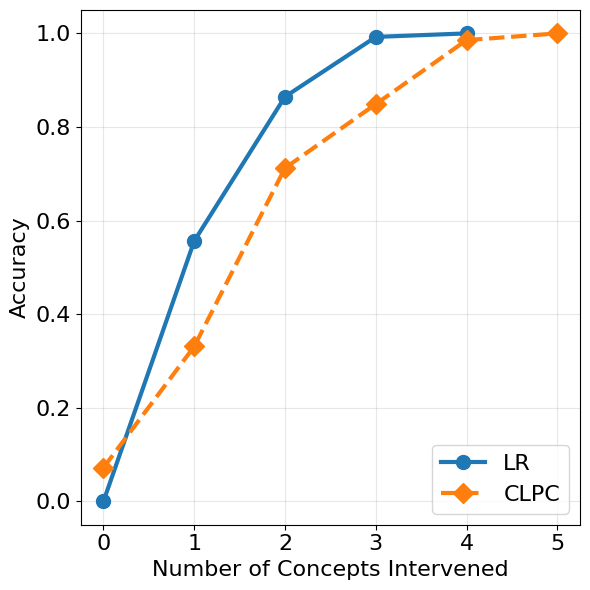

In [ ]:
# Compare all models
model_results = {
    'LR': lr_accuracies,
    'CLPC': proto_accuracies,
    # 'CLC-D': clc_d_accuracies
}

plot_intervention_results(model_results, use_dataset)

In [ ]:
clc_model.get_binary_prototypes()

tensor([[1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
         0.],
        [0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
         0.],
        [0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
         0.],
        [1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
         0.],
        [1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
         0.]], device='mps:0', grad_fn=<IndexPutBackward0>)

# Analysis of Incorrect Classifications
This section can be uncommented and used for further analysis of misclassified instances.

In [ ]:
# Additional analysis code can be placed here
# For example:
#
# def analyze_misclassifications(model, C_hat, Y_true, model_name):
#     """
#     Analyze misclassified instances for a given model.
#     """
#     if isinstance(C_hat, torch.Tensor):
#         predictions = model.predict(C_hat)
#         misclassified = (predictions != Y_true)
#         misclassified_indices = torch.where(misclassified)[0].cpu().numpy()
#     else:
#         predictions = model.predict(C_hat)
#         misclassified = (predictions != Y_true)
#         misclassified_indices = np.where(misclassified)[0]
#
#     print(f"{model_name} - Total misclassified: {len(misclassified_indices)}")
#
#     # Further analysis...
#
#     return misclassified_indices